In [23]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

In [24]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),         
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])


In [25]:
# Specify the paths to your train and test datasets
train_dataset_path = 'C:\\Users\\victus\\Desktop\\University\\SIS 421\\ImageDatasets\\BioDataset\\train'
test_dataset_path = 'C:\\Users\\victus\\Desktop\\University\\SIS 421\\ImageDatasets\\BioDataset\\test'


# Load the datasets using ImageFolder
trainset = ImageFolder(root=train_dataset_path, transform=transform)
testset = ImageFolder(root=test_dataset_path, transform=transform)

# Print out the classes found in the datasets
print(trainset.classes)
print(testset.classes)

# Print out the size of the datasets
print(len(trainset), len(testset))

['B', 'N']
['B', 'N']
59922 16726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

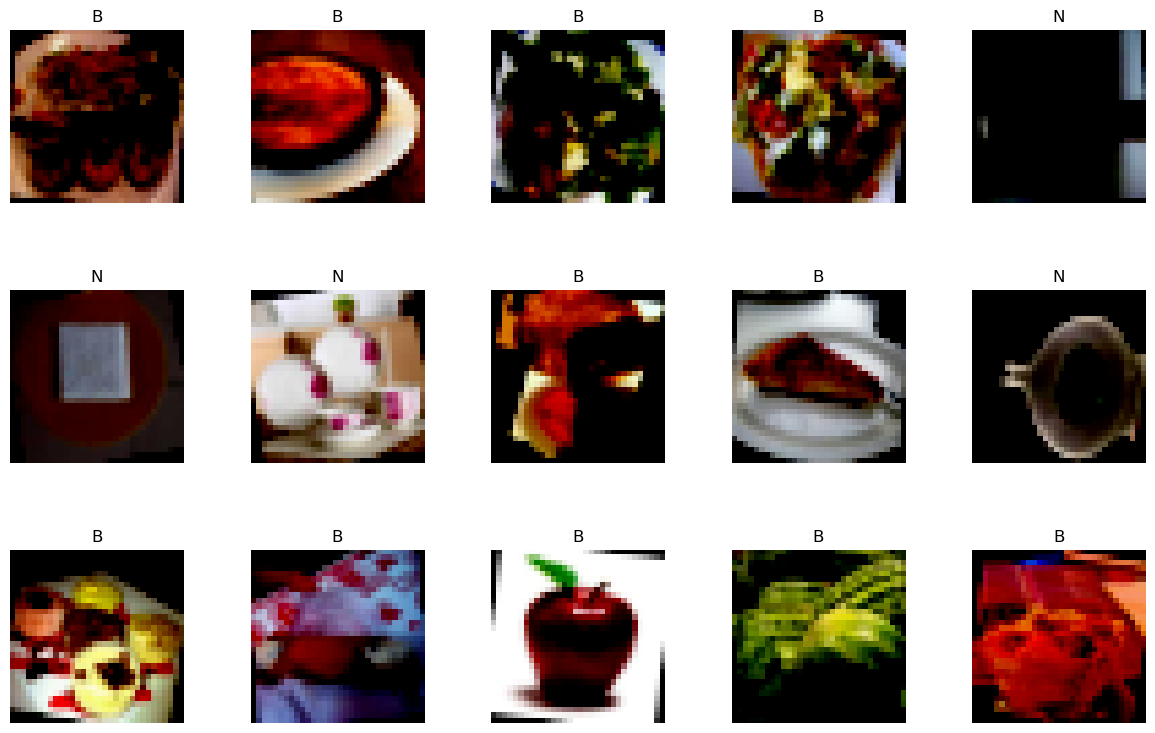

In [26]:
r, c = 3, 5
plt.figure(figsize=(c*3, r*3))

for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        # Transpose image data to shape (224, 224, 3)
        img_transposed = np.transpose(img.numpy(), (1, 2, 0))
        plt.imshow(img_transposed)
        plt.axis('off')
        plt.title(trainset.classes[label])  # Use label to get the corresponding class name

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [27]:
train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:50000], train_images[50000:], train_images[:9000]
y_train, y_val, y_subset = train_labels[:50000], train_labels[50000:], train_labels[:9000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((50000, 3, 32, 32), (9922, 3, 32, 32), (16726, 3, 32, 32), (9000, 3, 32, 32))

In [28]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(50000, 9922)

In [29]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=2):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

def fit(model, dataloader, optimizer, scheduler=None, epochs=200, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [30]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# aumenta el lr por 5 epochs, luego decrece
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=100)

Mejor modelo guardado con acc 0.80035 en epoch 1
Mejor modelo guardado con acc 0.84925 en epoch 2
Mejor modelo guardado con acc 0.85104 en epoch 3
Epoch 10/100 loss 0.22951 acc 0.90653 val_loss 0.36249 val_acc 0.84889 lr 0.00842
Mejor modelo guardado con acc 0.86463 en epoch 14
Mejor modelo guardado con acc 0.87720 en epoch 18
Mejor modelo guardado con acc 0.88767 en epoch 19
Epoch 20/100 loss 0.15652 acc 0.93830 val_loss 0.41762 val_acc 0.84593 lr 0.00446
Epoch 30/100 loss 0.08358 acc 0.97107 val_loss 0.49391 val_acc 0.85441 lr 0.00050
Epoch 40/100 loss 0.12477 acc 0.95192 val_loss 0.53466 val_acc 0.83922 lr 0.00842
Epoch 50/100 loss 0.08153 acc 0.97035 val_loss 0.53426 val_acc 0.84948 lr 0.00446
Epoch 60/100 loss 0.04222 acc 0.98570 val_loss 0.64232 val_acc 0.84631 lr 0.00050
Epoch 70/100 loss 0.08336 acc 0.96873 val_loss 0.58365 val_acc 0.84895 lr 0.00842
Epoch 80/100 loss 0.05435 acc 0.98097 val_loss 0.59164 val_acc 0.85826 lr 0.00446
Epoch 90/100 loss 0.02858 acc 0.99058 val_loss 

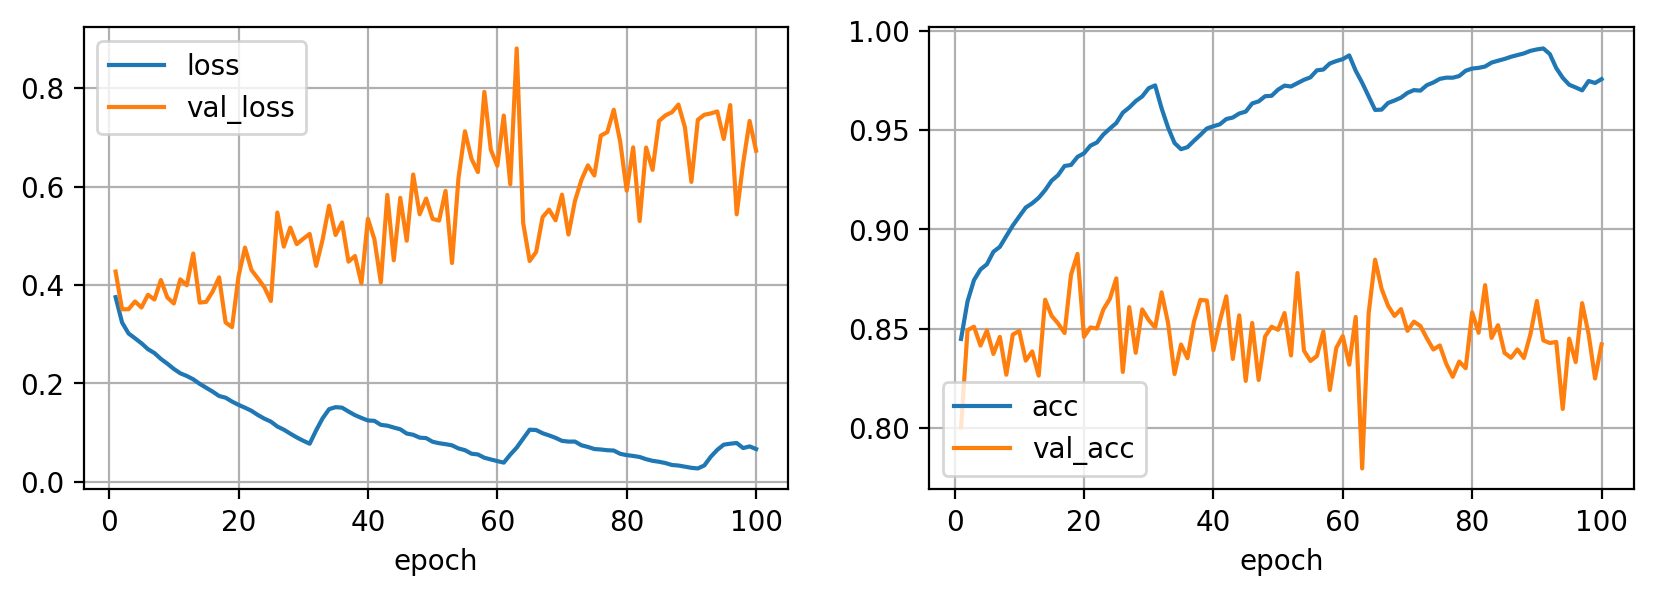

In [31]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist_cycle).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist_cycle).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [32]:
mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([-0.0005603 ,  0.00019225,  0.00042769,  0.00042648,  0.0004079 ,
         0.0003909 ,  0.00037382,  0.00035714,  0.00034201,  0.0003295 ,
         0.00032211,  0.00031755,  0.00031457,  0.00031356,  0.00031513,
         0.00031534,  0.00031692,  0.00031748,  0.00031598,  0.0003193 ,
         0.00032322,  0.00032799,  0.00033526,  0.0003443 ,  0.00035847,
         0.00037421,  0.00039193,  0.00040967,  0.00042684,  0.00042613,
         0.00019004, -0.00056181], dtype=float32),
 array([0.00260974, 0.00248479, 0.00241917, 0.00238495, 0.00234747,
        0.00233237, 0.00230127, 0.00227483, 0.00224992, 0.0022303 ,
        0.00221316, 0.00219617, 0.00218853, 0.00218668, 0.00218946,
        0.00219244, 0.00219218, 0.00218928, 0.00218712, 0.0021894 ,
        0.00219886, 0.00221304, 0.00223256, 0.00225308, 0.00227672,
        0.00230264, 0.00233388, 0.00234968, 0.00238723, 0.00242044,
        0.00248586, 0.00261009], dtype=float32))

In [33]:
train_images_norm = ((train_images / 255) - mean) / std
train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

(array([-5.2776543e-04,  2.8152374e-04, -5.9462839e-04, -7.5182016e-04,
         2.7158792e-04, -4.1005437e-04,  2.0338628e-04, -2.4087703e-05,
        -6.3793350e-04,  3.8859143e-04, -8.9516092e-05,  3.2199096e-05,
        -1.8443626e-04, -5.5902509e-04, -1.6761293e-04,  9.5936002e-06,
        -2.6321347e-04, -1.9603583e-04,  3.7209454e-04, -1.4728744e-04,
        -1.6450962e-04,  1.1287342e-03,  1.2607696e-04, -1.6643923e-04,
         2.6702252e-04,  2.2184581e-04, -3.2207655e-04,  3.6058552e-04,
        -4.7741245e-04, -3.6889766e-04,  3.3977671e-04, -7.1305217e-04],
       dtype=float32),
 array([1.0003036 , 1.0031438 , 1.0004318 , 1.0019114 , 1.0005578 ,
        0.99981415, 1.0007927 , 0.99901485, 0.997614  , 0.9961144 ,
        0.9966128 , 0.9979389 , 0.99726194, 0.9967654 , 0.9969072 ,
        0.9973412 , 0.9974072 , 0.99770266, 0.99726915, 0.9973058 ,
        0.99818456, 0.99762595, 0.9970249 , 0.99769896, 0.99956024,
        0.9983485 , 0.9985216 , 1.0007163 , 1.0022911 , 1.00

In [34]:
X_test_norm = np.array([(np.array(img)/255. - mean) / std for img, label in testset])

X_train_norm, X_val_norm, X_subset_norm = train_images_norm[:50000], train_images_norm[50000:], train_images_norm[:9000]

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape, X_subset_norm.shape

((50000, 3, 32, 32), (9922, 3, 32, 32), (16726, 3, 32, 32), (9000, 3, 32, 32))

In [35]:
dataset_norm = {
    'train': Dataset(X_subset_norm, y_subset),
    'val': Dataset(X_val_norm, y_val),
}

dataloader_norm = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset_norm['train']), len(dataset_norm['val'])

(9000, 9922)

In [36]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.86365 en epoch 1
Mejor modelo guardado con acc 0.87745 en epoch 7
Epoch 10/200 loss 0.22078 acc 0.91091 val_loss 0.33481 val_acc 0.86850 lr 0.00100
Epoch 20/200 loss 0.16029 acc 0.93870 val_loss 0.40379 val_acc 0.85363 lr 0.00100
Mejor modelo guardado con acc 0.88128 en epoch 24
Epoch 30/200 loss 0.12447 acc 0.95284 val_loss 0.44466 val_acc 0.86599 lr 0.00100
Epoch 40/200 loss 0.10521 acc 0.95949 val_loss 0.53608 val_acc 0.84090 lr 0.00100
Epoch 50/200 loss 0.07970 acc 0.97019 val_loss 0.60938 val_acc 0.83965 lr 0.00100
Epoch 60/200 loss 0.07145 acc 0.97477 val_loss 0.75179 val_acc 0.82872 lr 0.00100
Epoch 70/200 loss 0.05967 acc 0.97793 val_loss 0.52004 val_acc 0.87222 lr 0.00100
Epoch 80/200 loss 0.05386 acc 0.98089 val_loss 0.68678 val_acc 0.84254 lr 0.00100
Epoch 90/200 loss 0.04978 acc 0.98257 val_loss 0.71635 val_acc 0.83055 lr 0.00100
Epoch 100/200 loss 0.04675 acc 0.98315 val_loss 0.69140 val_acc 0.84812 lr 0.00100
Epoch 110/200 loss 0.04084 acc 

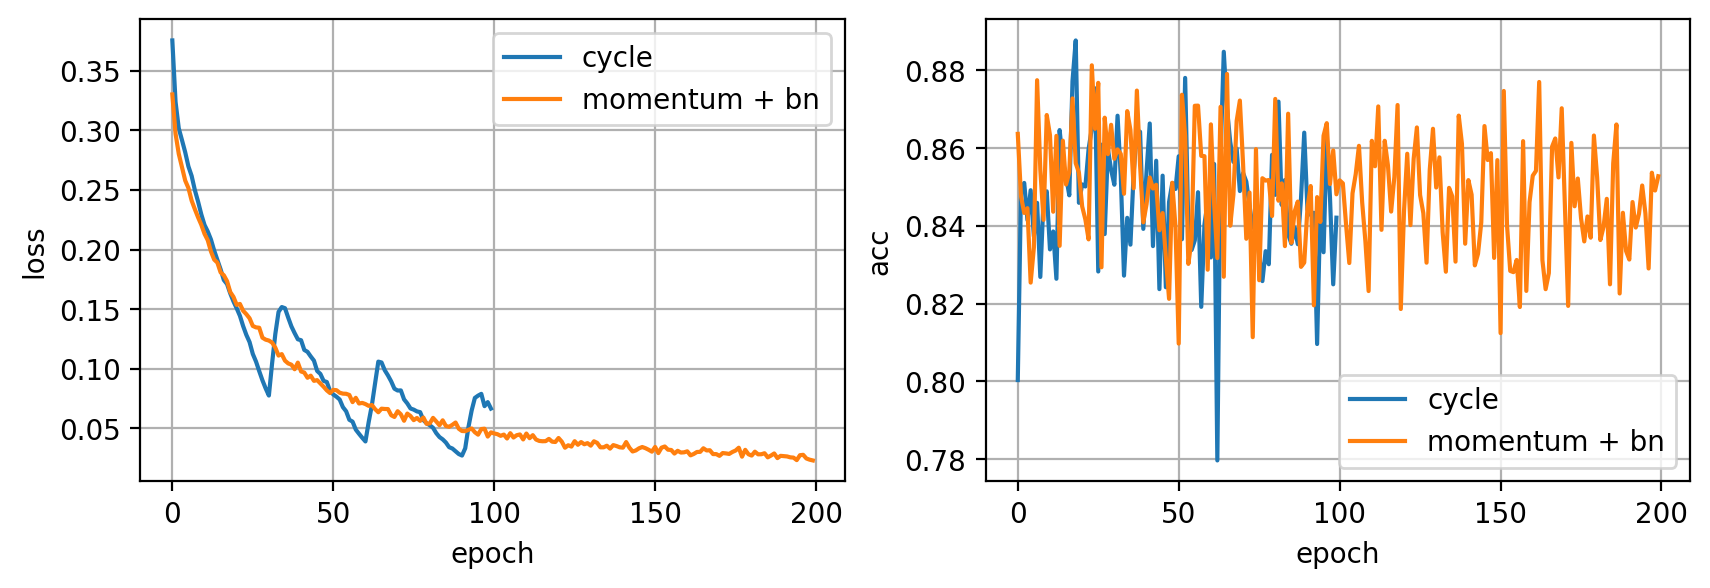

In [37]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_cycle['loss'], label="cycle")
ax.plot(hist_bn['loss'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.plot(hist_bn['val_acc'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()